In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit

In [52]:
# @cuda.jit(nopython = True,chache=True)
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


@jit(nopython = True,cache=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y



# @cuda.jit#(nopython = True,chache=True)
@jit(nopython = True,cache=True)
def Kuramoto_SOL_CHIMERA(Theta,t,omega,N,Kij,alpha):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]

    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Kij*np.sin(theta_j - theta_i - alpha),axis=0)
    Theta[:N] = dtheta
    return Theta

@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

@jit(nopython=True)
def RK4_ZZ2(f, y0, t, args=()):
    n = len(t)
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y, t[i], *args)
        k2,_,_,_,_ = f(y + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y + k3 * h, t[i] + h, *args)
        y = y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return Z1as,Z1bs,Z2as,Z2bs



@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

A = 0.2
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2


def myFun(u,t=0,A=0.1,beta=0.1):
	r,psi = u[0],u[1]
	nu = (1-A)/2
	mu = (1+A)/2
	alpha = np.pi/2 - beta
	dr = (1-r**2)/2 *(mu*r*np.cos(alpha)+nu*np.cos(psi-alpha))
	dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
	return (dr,dpsi)

@jit(nopython= True)
def myFun2(u,t=0,A=0.1,beta=0.1):
	r,psi = u[0],u[1]
	nu = (1-A)/2
	mu = (1+A)/2
	alpha = np.pi/2 - beta
	dr = (1-r**2)/2 *(mu*r*np.cos(alpha)+nu*np.cos(psi-alpha))
	dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
	return np.array([dr,dpsi])

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_3543/1605782460.py:17: RuntimeWarning: divide by zero encountered in divide
  dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_3543/3156308475.py:35: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contourf(Y.T,X.T,M.T,color=M.T,zorder=3,levels=[0-1e-4,0+1e-4])


Text(0.5, 1.0, 'A=0.3,$\\beta$=0.15')

/Users/gugyoungkim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


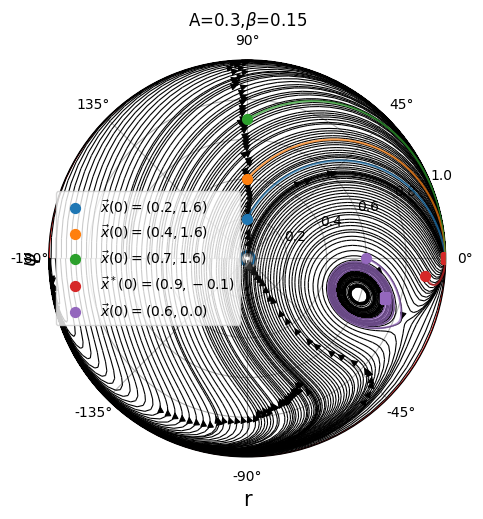

In [113]:
A = 0.3
beta = 0.15

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.sca(ax)

t = np.arange(0,3000,0.1)
u0s = [[0.2,np.pi/2],[0.4,np.pi/2],[0.7,np.pi/2],[0.9,-0.1],[0.6,0.]]
for i,u0 in enumerate(u0s):

	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(A,beta))
	if i == 3:
		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
	else:	
		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
	plt.scatter(u[-1,1]%(np.pi*2),u[-1,0],s=50,marker='s',zorder=7,color=c.get_facecolor())
	plt.plot(u[:,1],u[:,0],alpha=0.7,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))



plt.legend(loc=3)
x = np.linspace(0,1.5,200)
y = np.linspace(-np.pi,np.pi,400)
X,Y = np.meshgrid(x,y)

U,V = myFun([X,Y],A=A,beta=beta)
M = (np.hypot(U,V))

xs = np.linspace(-3,-1e-5,1000)
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()
ax = plt.gca()
ax.streamplot(Y.T,X.T,V.T,U.T,color=M.T,zorder=3,density=2,cmap = 'gray',linewidth=0.8,broken_streamlines=False,)
ax.contourf(Y.T,X.T,M.T,color=M.T,zorder=3,levels=[0-1e-4,0+1e-4])
ax.axhline(1,color='RED')
plt.tight_layout()


# plt.colorbar()
plt.ylim(0,1)
plt.xlim(-np.pi,np.pi)
# plt.ylim(-0.5,0.5)
ax =plt.gca()
ax.grid(True)
ax.minorticks_on()

plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('r',fontsize=15)
plt.ylabel(r'$\psi$',fontsize=15)
plt.legend()


psi = -2*beta -2*beta**2 - 7/3*beta**3 + 20*beta**4/3 + 181*beta**5/60
plt.title(rf'A={A},$\beta$={beta}')

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

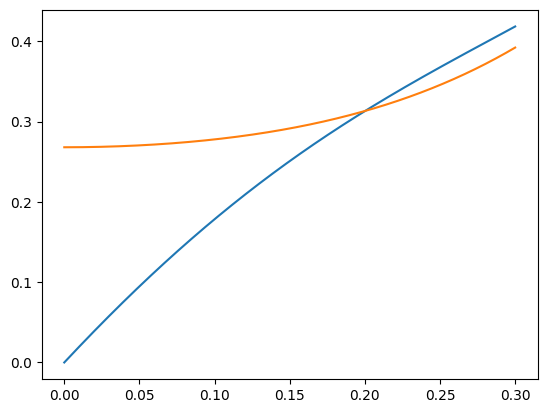

In [112]:
betas = np.linspace(0,0.3,1000)

def F_SN(beta):
    A = 2*beta - 2*beta**2  - 7/3 * beta**3 +20/3*beta**4 +181*beta**5/60
    return A

def F_H(beta):
    A = 2-np.sqrt(3) +(4*np.sqrt(3) - 6)* beta**2 + (26/np.sqrt(3)-10)*beta**4
    return A
plt.plot(betas,F_SN(betas))
plt.plot(betas,F_H(betas))

In [114]:
u0 = [0.6,0]
r,psi = RK4(myFun2,np.array(u0,dtype=float),t,args=(A,beta)).T

In [115]:
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def dist_ab(x, a):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (a_+a_.conjugate()))
    return f.real  # 확률밀도함수는 실수부만 사용합니다.

# 파라미터 설정
a = r[0]*np.exp(-1j*psi[0])

# x 값 범위 설정
x = np.linspace(-np.pi, np.pi, 10000)

# 확률 밀도 함수 계산
pdf = dist_ab(x, a)

# 수치적 적분을 사용하여 CDF 계산
cdf = cumtrapz(pdf, x, initial=0)
cdf /= cdf[-1]  # 정규화

# CDF를 바탕으로 분위수 함수 구현
quantile_func = interp1d(cdf, x, kind='nearest', fill_value='extrapolate')

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_3543/1930692884.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf = cumtrapz(pdf, x, initial=0)


In [116]:

N = 1000
N1 = N2 = N
ps = (np.arange(N+1)[:-1] + 1)/(N+1)

theta1 = np.zeros(N1)
theta2 = quantile_func(ps)
Theta = np.r_[theta1,theta2]

In [117]:
@jit(nopython=True)
def Kuramoto_MF_SOLVABLE(Theta,t,Na,Nb,nu,mu,alpha):
    dtheta = np.zeros(Na+Nb)
    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  (mu*Z1a+nu*Z1b)
    ZZb =  (mu*Z1b+nu*Z1a)
    dtheta[:Na] = ((A*ZZa)*EA).imag
    dtheta[Na:] = ((A*ZZb)*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b

In [118]:
# beta = 0.1
nu = (1-A)/2
mu = (1+A)/2
alpha = np.pi/2 - beta

In [119]:
N1 = N2 = N
K = 1
thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_SOLVABLE,Theta.copy(),t,args=(N1,N2,nu,mu,alpha))
R1_S = np.abs(Z1as)
R2_S = np.abs(Z1bs)
Q1_S = np.abs(Z2as)
Q2_S = np.abs(Z2bs)

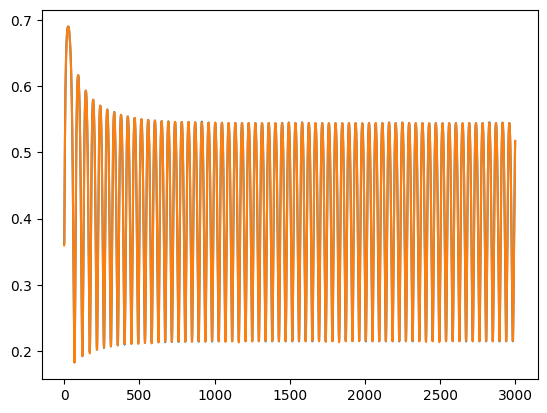

In [120]:
plt.plot(t,R2_S**2)
plt.plot(t,Q2_S)
# plt.xlim(2000,3000)


(2000.0, 3000.0)

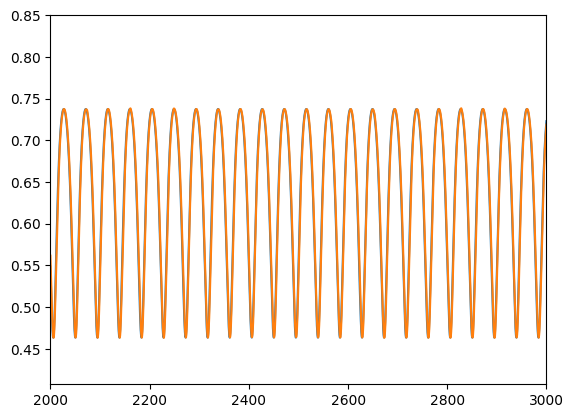

In [121]:
plt.plot(t,r)
plt.plot(t,R2_S)
plt.xlim(2000,3000)

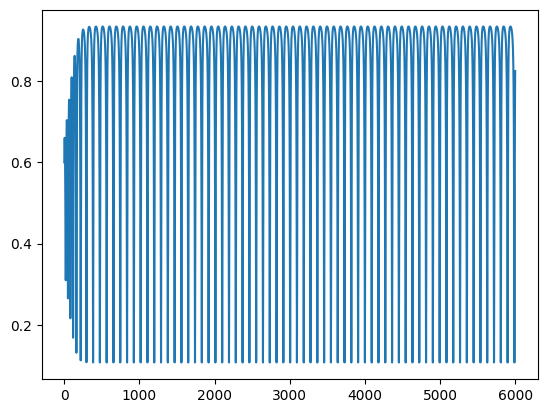

In [27]:
plt.plot(t,r)

In [ ]:
# alpha = 1.3
# beta = 0.2
# eta1 = 0.1
# eta2 = 0.2

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
plt.figure(dpi=500)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.sca(ax)

# u0s = [[0.2,np.pi/2],[0.4,np.pi/2],[0.7,np.pi/2],[0.9,-0.1],[0.6,0.]]
# for i,u0 in enumerate(u0s):

# 	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(args,))
# 	if i == 3:
# 		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
# 	else:	
# 		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
# 	plt.scatter(u[-1,1]%(np.pi*2),u[-1,0],s=50,marker='s',zorder=7,color=c.get_facecolor())
# 	plt.plot(u[:,1],u[:,0],alpha=0.7,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))


xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
# plt.xlabel('x',fontsize=15)
# plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')


plt.legend(loc=3)
x = np.linspace(0,1.5,200)
y = np.linspace(-np.pi,np.pi,400)
X,Y = np.meshgrid(x,y)

U,V = myFun([X,Y],0,args)
M = (np.hypot(U,V))

xs = np.linspace(-3,-1e-5,1000)
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()
ax = plt.gca()
ax.streamplot(Y.T,X.T,V.T,U.T,color=M.T,zorder=3,density=2,cmap = 'gray',linewidth=0.8,broken_streamlines=False,)
ax.contourf(Y.T,X.T,M.T,color=M.T,zorder=3,levels=[0-1e-4,0+1e-4])
ax.axhline(1,color='RED')
plt.tight_layout()